# Result visualization for QUE+LOG

We use **queue imbalance** feature for forecasting **mid price indicator** using Logistic Regression.

We show scores summary using MCC and ROC area score.

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils import roc_results, gdf_pca, stocks_numbers
from lob_data_utils.svm_calculation import lob_svm

import os


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_length = 24000
data_dir = 'res_que_log'
should_save_fig = False

In [3]:
df_scores = pd.DataFrame()
for f in os.listdir(data_dir):
    if 'csv' in f:
        df_scores = df_scores.append(pd.read_csv(os.path.join(data_dir, f)), ignore_index=True)

,test_matthews,matthews,test_roc_auc,roc_auc
count,15.000000,15.000000,15.000000,15.000000
mean,0.115979,0.119609,0.567714,0.570067
std,0.025166,0.025908,0.019944,0.020311
min,0.047732,0.059986,0.524008,0.530117
25%,0.107898,0.105831,0.557400,0.561098
50%,0.123369,0.130257,0.569974,0.574661
75%,0.132348,0.136362,0.577048,0.578699
max,0.150063,0.148009,0.600698,0.606098


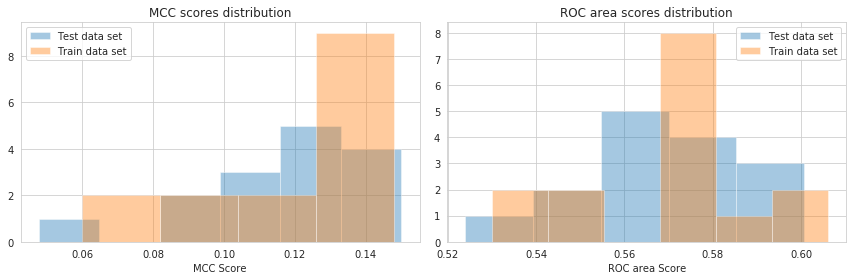

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(df_scores['test_matthews'], kde=False, label='Test data set', ax=ax1)
sns.distplot(df_scores['matthews'], kde=False, label='Train data set', ax=ax1)

ax1.legend()
ax1.set_xlabel('MCC Score')
ax1.set_title('MCC scores distribution')

sns.distplot(df_scores['test_roc_auc'], kde=False, label='Test data set', ax=ax2)
sns.distplot(df_scores['roc_auc'], kde=False, label='Train data set', ax=ax2)

ax2.legend()
ax2.set_xlabel('ROC area Score')
ax2.set_title('ROC area scores distribution')
plt.tight_layout()
#plt.savefig('results_log_que_score_dist.png')

df_scores[['test_matthews', 'matthews', 'test_roc_auc', 'roc_auc']].describe()

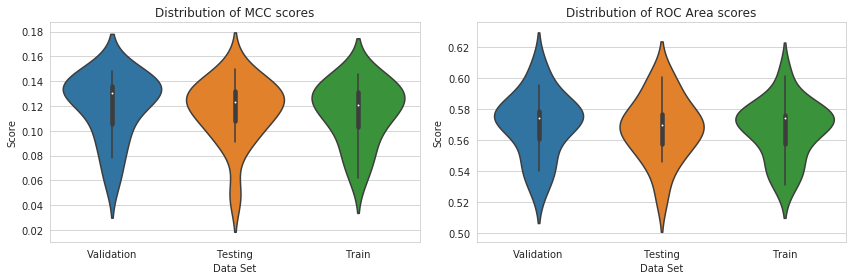

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'matthews', 'roc_auc', 
           'test_matthews', 'test_roc_auc', 'train_matthews', 'train_roc_auc']

df = df_scores[columns].copy()
df.rename(columns={'matthews': 'Validation', 'test_matthews': 'Testing', 'train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'roc_auc', 'test_roc_auc', 'train_roc_auc'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_scores[columns].copy()
df.rename(columns={'roc_auc': 'Validation', 'test_roc_auc': 'Testing', 'train_roc_auc': 'Train'}, inplace=True)
df = df.melt(['stock', 'matthews', 'test_matthews', 'train_matthews'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if should_save_fig:
    plt.savefig('violin_distribution_scores_log_que.png')

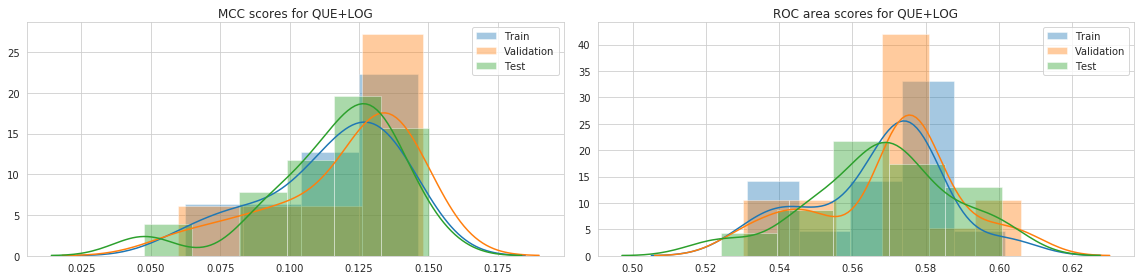

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

sns.distplot(df_scores[['train_matthews']], label='Train', ax=ax1)
sns.distplot(df_scores[['matthews']], label='Validation', ax=ax1)
sns.distplot(df_scores[['test_matthews']], label='Test', ax=ax1)
ax1.legend()
ax1.set_title('MCC scores for QUE+LOG')

sns.distplot(df_scores[['train_roc_auc']], label='Train', ax=ax2)
sns.distplot(df_scores[['roc_auc']], label='Validation', ax=ax2)
sns.distplot(df_scores[['test_roc_auc']], label='Test', ax=ax2)
ax2.legend()
ax2.set_title('ROC area scores for QUE+LOG')
plt.tight_layout()
if should_save_fig:
    plt.savefig('results_que_log.png')

In [7]:
print(df_scores[['train_matthews', 'matthews', 'test_matthews', 
        'train_roc_auc', 'roc_auc', 'test_roc_auc']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  train\_matthews &   matthews &  test\_matthews &  train\_roc\_auc &    roc\_auc &  test\_roc\_auc \\
\midrule
count &       15.000000 &  15.000000 &      15.000000 &      15.000000 &  15.000000 &     15.000000 \\
mean  &        0.114807 &   0.119609 &       0.115979 &       0.566764 &   0.570067 &      0.567714 \\
std   &        0.024494 &   0.025908 &       0.025166 &       0.018415 &   0.020311 &      0.019944 \\
min   &        0.062188 &   0.059986 &       0.047732 &       0.531253 &   0.530117 &      0.524008 \\
25\%   &        0.102909 &   0.105831 &       0.107898 &       0.557326 &   0.561098 &      0.557400 \\
50\%   &        0.120714 &   0.130257 &       0.123369 &       0.574345 &   0.574661 &      0.569974 \\
75\%   &        0.131185 &   0.136362 &       0.132348 &       0.576400 &   0.578699 &      0.577048 \\
max   &        0.146106 &   0.148009 &       0.150063 &       0.601743 &   0.606098 &      0.600698 \\
\bottomrule
\end{tabula

#### MCC scores per stock

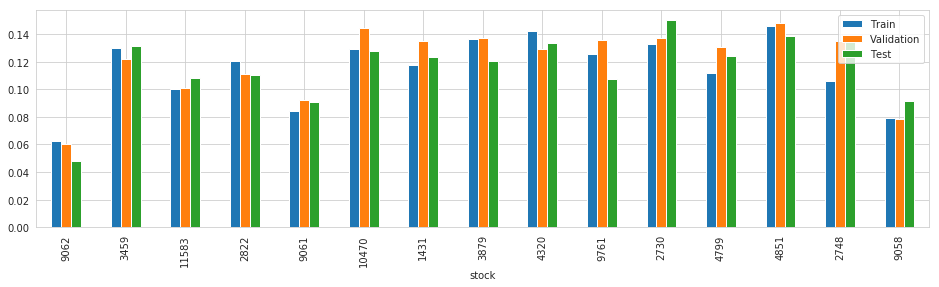

In [8]:
df_scores.index = df_scores['stock']
df_scores[['train_matthews', 'matthews', 'test_matthews']].plot(kind='bar', figsize=(16, 4))
plt.legend(['Train', 'Validation', 'Test'])